## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

Зафиксируем random seed

In [2]:
RS = 156872

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')
dataset_path = '/datasets/faces/final_files/'

In [4]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
df['file_name'].duplicated().sum()

0

Таблица с возрастами соответствует описанию, дубликаты в названиях фото отсутствуют 

Посмотрим на распределение 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
df['real_age'].value_counts().to_frame('count values')

,count values
30,317
25,315
27,229
26,226
28,217
...,...
96,2
93,1
100,1
91,1


In [8]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


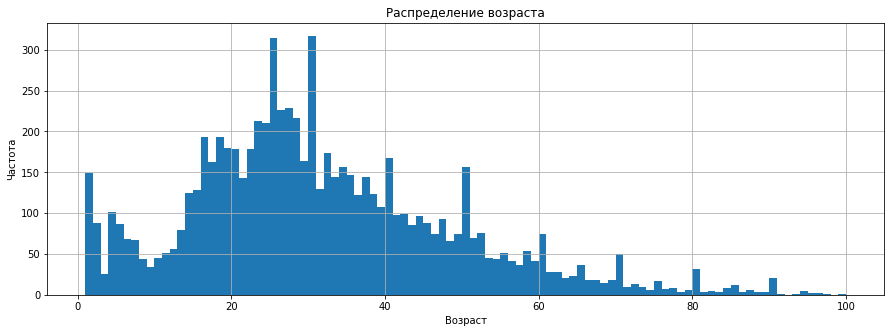

In [13]:
df['real_age'].hist(bins=99, figsize=(15, 5));
plt.xlabel("Возраст")
plt.ylabel("Частота")
plt.title("Распределение возраста")
plt.show()

большинство фотографий с людьми от 10 до 60 лет, имеются фото с возраставми от 1 до 100 лет\
Присудствуют пики на 25, 30, 40, 50, 60, 70, 80 и 90\
они могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его

Напишим функцию для просмотра случайных фотографий, их размера, и возраста человека

In [10]:
def random_img(n, file_name_column, dataset_path, real_age_column):
    """
    Выводит случайные изображения из датасета и соответствующие им возрасты и размер изображения.

    Аргументы:
    - n: Количество случайных изображений для отображения.
    - file_name_column: Столбец с именами файлов изображений.
    - dataset_path: Путь к датасету с изображениями.
    - real_age_column: Столбец с реальными возрастами.

    """
    file_name = file_name_column.sample(n)
    real_age = real_age_column.loc[file_name.index]
    fig = plt.figure(figsize=(15, 9))
    for i in range(n):
        image = Image.open(dataset_path + file_name.iloc[i])
        ax = fig.add_subplot(3, 5, i+1)
        ax.imshow(np.array(image))
        ax.set_title(f'Фото')
        ax.axis('off')
        ax.text(0.5, -0.1, f'Возраст: {real_age.iloc[i]}\nРазмер: {image.size}', fontsize=12, color='black',
                transform=ax.transAxes, backgroundcolor='white', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))
    plt.tight_layout()
    plt.show()

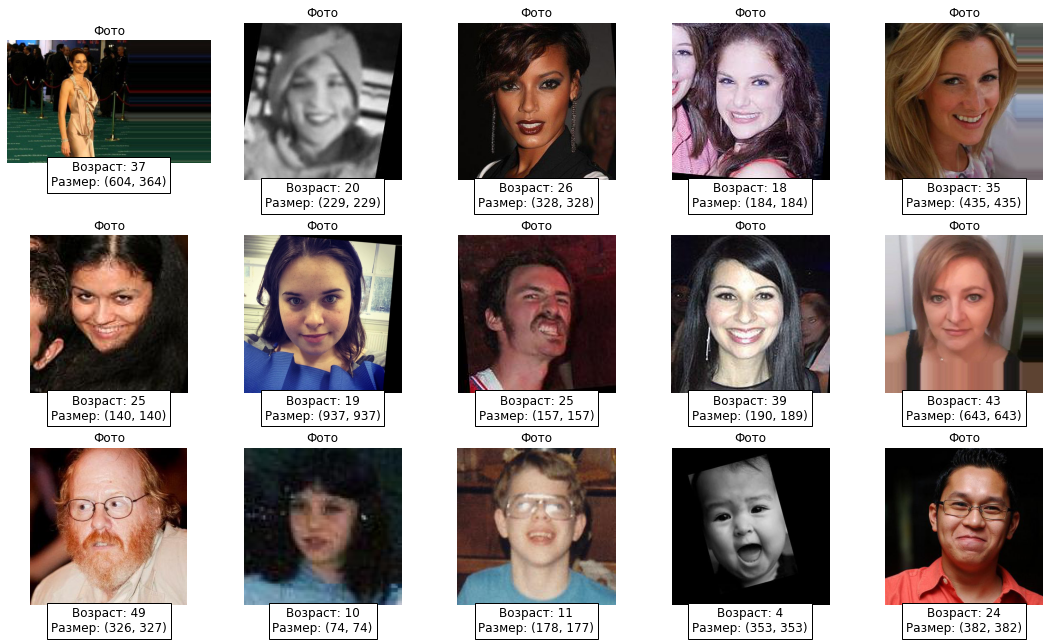

In [11]:
random_img(15, df['file_name'], dataset_path, df['real_age'])

Возраст соответствует фото, размеры различныйе.

Из описания на [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/) на фотографиях из этого набора данных изображены обрезанные и повернутые лица с обрезанным прямоугольным полем, охватывающим около 40% исходного изображения лица.

### Вывод

- Пропуски в данных отсутствуют,
- в наборе фотографии разных размеров
- Большинство лиц от 13 до 60
- Лица на фото развернуты

## Обучение модели

```python
train_datagen = ImageDataGenerator(rescale=1./255)

# Генератор данных
datagen = ImageDataGenerator(
    rescale=1./255,
    #horizontal_flip=True,
    #vertical_flip=True,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #rotation_range = 90,
    validation_split=0.25)

input_shape = (224, 224, 3)
# Выбираем learning_rate
optimizer = Adam(learning_rate=0.0005)

# Функции загрузки данных
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=RS)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=RS)
 
    return test_gen_flow


# Создание модели
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPooling2D())
    
    #model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model
```

Результат обучения модели

```

Train for 178 steps, validate for 60 steps
Epoch 1/50
2023-06-13 03:27:37.591325: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-13 03:27:37.877857: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 201.9449 - mae: 10.7318 - val_loss: 880.0986 - val_mae: 24.8798
Epoch 2/50
178/178 - 38s - loss: 108.1572 - mae: 7.9456 - val_loss: 912.0492 - val_mae: 25.4501
Epoch 3/50
178/178 - 37s - loss: 57.5252 - mae: 5.8343 - val_loss: 660.5225 - val_mae: 20.7925
Epoch 4/50
178/178 - 38s - loss: 31.4592 - mae: 4.2995 - val_loss: 325.0685 - val_mae: 13.8697
Epoch 5/50
178/178 - 37s - loss: 20.8434 - mae: 3.4678 - val_loss: 118.3875 - val_mae: 8.0280
Epoch 6/50
178/178 - 38s - loss: 15.5720 - mae: 3.0222 - val_loss: 88.6479 - val_mae: 6.8480
Epoch 7/50
178/178 - 37s - loss: 12.6028 - mae: 2.6800 - val_loss: 96.2512 - val_mae: 7.2571
Epoch 8/50
178/178 - 37s - loss: 9.9012 - mae: 2.3985 - val_loss: 74.0376 - val_mae: 6.4194
Epoch 9/50
178/178 - 37s - loss: 8.9800 - mae: 2.2620 - val_loss: 72.4714 - val_mae: 6.4833
Epoch 10/50
178/178 - 38s - loss: 8.0868 - mae: 2.1356 - val_loss: 76.9236 - val_mae: 6.5023
Epoch 11/50
178/178 - 37s - loss: 8.3371 - mae: 2.1820 - val_loss: 72.3650 - val_mae: 6.4830
Epoch 12/50
178/178 - 38s - loss: 9.4258 - mae: 2.3119 - val_loss: 74.3008 - val_mae: 6.4472
Epoch 13/50
178/178 - 38s - loss: 9.9550 - mae: 2.3911 - val_loss: 75.7025 - val_mae: 6.3470
Epoch 14/50
178/178 - 38s - loss: 10.8763 - mae: 2.4950 - val_loss: 81.4961 - val_mae: 6.5901
Epoch 15/50
178/178 - 38s - loss: 12.2670 - mae: 2.6713 - val_loss: 80.7943 - val_mae: 6.6822
Epoch 16/50
178/178 - 38s - loss: 13.6980 - mae: 2.8095 - val_loss: 95.7797 - val_mae: 7.2130
Epoch 17/50
178/178 - 37s - loss: 14.5715 - mae: 2.8983 - val_loss: 88.5164 - val_mae: 7.0699
Epoch 18/50
178/178 - 38s - loss: 16.7554 - mae: 3.1081 - val_loss: 125.1339 - val_mae: 8.1127
Epoch 19/50
178/178 - 38s - loss: 24.7004 - mae: 3.6839 - val_loss: 459.0332 - val_mae: 16.2421
Epoch 20/50
178/178 - 37s - loss: 44.9700 - mae: 5.0999 - val_loss: 128.5629 - val_mae: 8.4451
Epoch 21/50
178/178 - 38s - loss: 35.8701 - mae: 4.5827 - val_loss: 113.0991 - val_mae: 7.7518
Epoch 22/50
178/178 - 37s - loss: 17.4072 - mae: 3.1204 - val_loss: 110.6584 - val_mae: 7.7431
Epoch 23/50
178/178 - 38s - loss: 9.1138 - mae: 2.2468 - val_loss: 77.6200 - val_mae: 6.4937
Epoch 24/50
178/178 - 38s - loss: 5.2008 - mae: 1.7040 - val_loss: 72.2673 - val_mae: 6.4803
Epoch 25/50
178/178 - 38s - loss: 3.4709 - mae: 1.3759 - val_loss: 72.3777 - val_mae: 6.2275
Epoch 26/50
178/178 - 37s - loss: 2.6410 - mae: 1.1918 - val_loss: 71.8368 - val_mae: 6.4498
Epoch 27/50
178/178 - 37s - loss: 2.0934 - mae: 1.0538 - val_loss: 67.8428 - val_mae: 6.1853
Epoch 28/50
178/178 - 38s - loss: 2.0093 - mae: 1.0373 - val_loss: 69.7053 - val_mae: 6.2515
Epoch 29/50
178/178 - 38s - loss: 1.8705 - mae: 0.9861 - val_loss: 69.2905 - val_mae: 6.1012
Epoch 30/50
178/178 - 38s - loss: 2.3131 - mae: 1.1185 - val_loss: 68.6149 - val_mae: 6.1915
Epoch 31/50
178/178 - 37s - loss: 2.9127 - mae: 1.2524 - val_loss: 71.2074 - val_mae: 6.2999
Epoch 32/50
178/178 - 37s - loss: 3.6223 - mae: 1.4243 - val_loss: 75.3554 - val_mae: 6.5254
Epoch 33/50
178/178 - 38s - loss: 4.4624 - mae: 1.6031 - val_loss: 73.0771 - val_mae: 6.2724
Epoch 34/50
178/178 - 38s - loss: 5.0337 - mae: 1.6953 - val_loss: 78.0624 - val_mae: 6.6969
Epoch 35/50
178/178 - 38s - loss: 5.6726 - mae: 1.7797 - val_loss: 77.3610 - val_mae: 6.4182
Epoch 36/50
178/178 - 38s - loss: 6.2790 - mae: 1.8719 - val_loss: 76.6220 - val_mae: 6.5306
Epoch 37/50
178/178 - 38s - loss: 7.7316 - mae: 2.1076 - val_loss: 74.4064 - val_mae: 6.3458
Epoch 38/50
178/178 - 38s - loss: 10.1923 - mae: 2.4216 - val_loss: 95.5979 - val_mae: 7.2605
Epoch 39/50
178/178 - 38s - loss: 26.2692 - mae: 3.6086 - val_loss: 605.9667 - val_mae: 19.4398
Epoch 40/50
178/178 - 37s - loss: 54.6172 - mae: 5.5626 - val_loss: 150.8375 - val_mae: 9.2094
Epoch 41/50
178/178 - 38s - loss: 23.0920 - mae: 3.6257 - val_loss: 80.9510 - val_mae: 6.6255
Epoch 42/50
178/178 - 39s - loss: 9.3784 - mae: 2.2848 - val_loss: 75.8077 - val_mae: 6.6244
Epoch 43/50
178/178 - 41s - loss: 4.1654 - mae: 1.5078 - val_loss: 72.0961 - val_mae: 6.4148
Epoch 44/50
178/178 - 40s - loss: 2.1236 - mae: 1.0721 - val_loss: 71.7642 - val_mae: 6.4034
Epoch 45/50
178/178 - 40s - loss: 1.3800 - mae: 0.8568 - val_loss: 68.9661 - val_mae: 6.2273
Epoch 46/50
178/178 - 40s - loss: 1.0368 - mae: 0.7428 - val_loss: 70.7976 - val_mae: 6.2833
Epoch 47/50
178/178 - 40s - loss: 1.1400 - mae: 0.7696 - val_loss: 68.7584 - val_mae: 6.1509
Epoch 48/50
Epoch 49/50
178/178 - 42s - loss: 1.2031 - mae: 0.7970 - val_loss: 71.6013 - val_mae: 6.3446
178/178 - 40s - loss: 1.5515 - mae: 0.9057 - val_loss: 68.2579 - val_mae: 6.1762
Epoch 50/50
178/178 - 40s - loss: 2.0462 - mae: 1.0522 - val_loss: 70.4424 - val_mae: 6.3235

```

## Анализ обученной модели

Для решения задачи была использована RsNet50.
использовались предварительно обученные веса для извлечения признаков изображений, добавлнены 3 полносвязных слоя.
`MAE` на валидационной выборке после 50 эпох равна `6,32` что меньше чем требовалось 

Модель определяет возраст человека по фото лица, ошибается при этом на 6-7 лет.

Модель может решить задачу определения возростной группы для предложения товара.\
Для контроля добросовестности кассиров при продаже алкоголя модель не подходит.